# Proyecto

El papel de la bolsa de valores en la historia financiera es innegable. Desde los individuos más influyentes hasta los inversores comunes, todos buscan asegurar sus ingresos y generar ganancias a través de inversiones. Sin embargo, como bien se menciona, no siempre se obtienen ganancias, y el riesgo es una constante en este mundo.

##Paso 1: instalar e importar bibliotecas

In [ ]:
!pip install -q yfinance prophet

In [ ]:
import numpy as np
import pandas as pd

import yfinance as yf

# Prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# VisualizaCION
import plotly.graph_objs as go

## Cargar los datos

En el segundo paso, los datos del precio de Microsoft se descargan de la API financiera de Yahoo. Estamos utilizando datos diarios de dos años de 2018 y 2024.

Yahoo Finance descarga datos con la fecha como índice. Usando reset_index, creamos un nuevo índice y usamos la fecha como columna. Esto se debe a que Prophet requiere que la variable de fecha y hora sea una columna para la entrada del modelo.

De forma predeterminada, la fecha es un tipo de cadena, pd.to_datetimela cambia a un formato DateTime.

In [ ]:
data = yf.download(tickers='MSFT',start='2018-01-01')

data.reset_index(inplace=True)

data['Date'] = pd.to_datetime(data['Date'])

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,80.080917,22483800
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,80.453590,26061400
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,81.161720,21912000
3,2018-01-05,87.660004,88.410004,87.430000,88.190002,82.167976,23407100
4,2018-01-08,88.199997,88.580002,87.599998,88.279999,82.251808,22113000
...,...,...,...,...,...,...,...
1582,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,15855500
1583,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,21029900
1584,2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,30276500
1585,2024-04-22,400.079987,402.850006,395.750000,400.959991,400.959991,20268600


In [ ]:
# Declarar la figura
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

En este tutorial, pronosticaremos el precio de cierre de Bitcoin. Prophet toma dos columnas como entradas, una columna de fecha y hora llamada `ds` y una columna de valor llamada `y`. Por lo tanto, debemos eliminar todas las demás columnas, cambiar el nombre de `Fecha` a `ds` y `Cerrar` a `y`.

In [ ]:
# # Mantener solo la fecha y el precio de cierre
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Cambiar el nombre de la fecha a ds y cerrar el precio a y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

df

,ds,y
0,2018-01-02,85.949997
1,2018-01-03,86.349998
2,2018-01-04,87.110001
3,2018-01-05,88.190002
4,2018-01-08,88.279999
...,...,...
1582,2024-04-17,411.839996
1583,2024-04-18,404.269989
1584,2024-04-19,399.119995
1585,2024-04-22,400.959991


## Paso 3: Train Test Split

En el paso $3$, se crean un conjunto de datos de entrenamiento y de prueba. No podemos utilizar la división aleatoria para los datos de series temporales porque provoca una fuga de datos de fechas futuras a fechas pasadas. Por lo general, se selecciona una fecha límite. Los datos anteriores a la fecha límite son el conjunto de datos de entrenamiento y los datos posteriores a la fecha límite se utilizan como conjunto de datos de prueba.

En este ejemplo, se utiliza `2024–03–22` como fecha límite. Los primeros $72$ meses se utilizan para la capacitación del modelo y el último mes se usa para pruebas.

In [ ]:
# Train test split
df_train = df[df['ds']<='2024-03-22']
df_test = df[df['ds']>'2024-03-22']

# Print .
print('El conjunto de datos de entrenamiento tiene', len(df_train), 'que, van desde', df_train['ds'].min(), 'hasta', df_train['ds'].max())
print(' El conjunto de datos de prueba tiene', len(df_test), 'que, van desde', df_test['ds'].min(), 'hasta', df_test['ds'].max())

El conjunto de datos de entrenamiento tiene 1566 que, van desde 2018-01-02 00:00:00 hasta 2024-03-22 00:00:00
 El conjunto de datos de prueba tiene 21 que, van desde 2024-03-25 00:00:00 hasta 2024-04-23 00:00:00


## Paso 4: Entrene el modelo de series temporales con Prophet

En el paso 4, entrenaremos el modelo de series de tiempo utilizando el conjunto de datos de entrenamiento.

`interval_widthespecifica` el intervalo de predicción. Cambiamos el valor predeterminado del intervalo de predicción del $80\%$ al $95\%$. Hace que el límite superior y el límite inferior de la predicción sean más amplios.

`n_changepointses` el número de puntos de cambio en la tendencia de la serie temporal. El valor predeterminado es $25$. Según la forma de los datos del precio de Bitcoin, se estableció en $7$.

In [ ]:
# Crea el modelo con una confianza interna del 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Ajusta el modelo
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa0r7638m/w1uq3ppx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa0r7638m/nqet14fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45191', 'data', 'file=/tmp/tmpa0r7638m/w1uq3ppx.json', 'init=/tmp/tmpa0r7638m/nqet14fg.json', 'output', 'file=/tmp/tmpa0r7638m/prophet_model_7yqp3ug/prophet_model-20240423181922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Paso 5: utilice el modelo Prophet para hacer predicciones

El paso 5 utiliza el modelo Profeta entrenado para hacer la predicción. Usamos los últimos 20 días para crear el marco de datos futuro. Esto es lo mismo que usar el conjunto de datos de prueba que creamos anteriormente.

El resultado de la predicción contiene mucha información. Mantuvimos el valor predicho yhaty su valor límite superior e inferior del intervalo de predicción.

In [ ]:
# Crear un marco de datos futuro para la predicción
future = m.make_future_dataframe(periods=21)

# Pronosticar los valores futuros del marco de datos
forecast = m.predict(future)

# Verifique los valores pronosticados y el pronóstico del límite
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1582,2024-04-08,421.062189,397.402173,447.265104
1583,2024-04-09,421.347672,396.010408,448.605905
1584,2024-04-10,422.200705,399.834556,450.157050
1585,2024-04-11,422.860995,397.824121,448.174577
1586,2024-04-12,423.380650,398.408027,449.830594


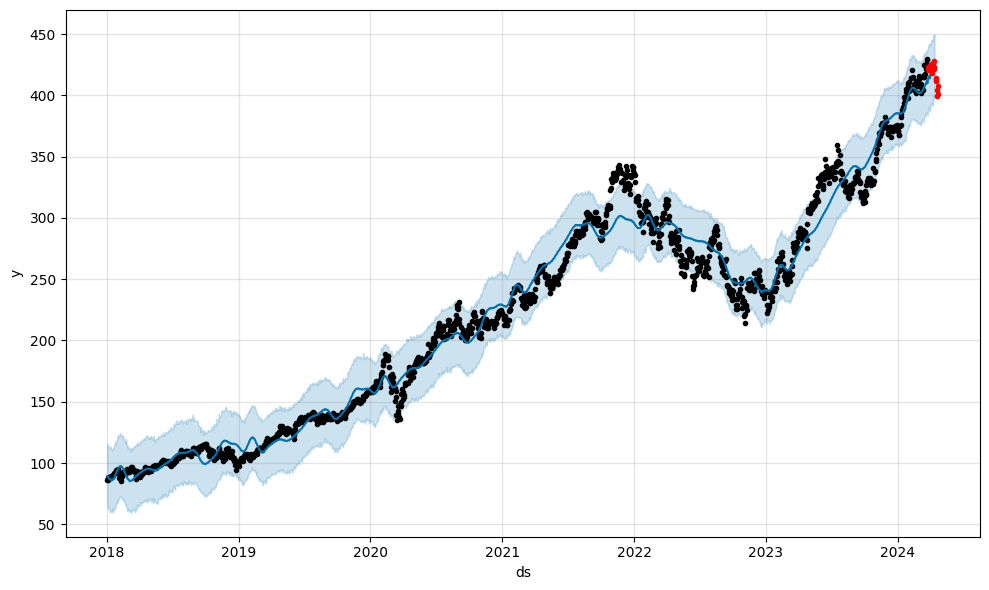

In [ ]:
# Visualizar el pronostico
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

En conclusión, podemos notar que el modelo coge una tendencia ascendente, algo que es parecido a la vida real, ya que la empresa va por buen camino.